# Exploratory Data Analysis

### Libraries

In [1]:
import json # json file processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

import cv2
import tifffile as tiff
from PIL import Image

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Utilities

In [2]:
# Config.
data_path = Path('/kaggle/input/hubmap-hacking-the-human-vasculature')

In [3]:
def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = list(json_file)
    
    json_data = []
    for json_str in data:
        json_data.append(json.loads(json_str))
        
    return pd.DataFrame(json_data)


def get_cartesian_coords(
    coords, 
    img_height
):
    """
    Reference: https://www.kaggle.com/code/leonidkulyk/eda-hubmap-hhv-interactive-annotations?scriptVersionId=130603722&cellId=7
    """
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

def read_tiff(
    image_id, 
    source = "train"
):
    array = tiff.imread(data_path/f"{source}/{image_id}.tif")
    image_array = Image.fromarray(array)
    return image_array


def plot_annotated_image(
    polygons_data, 
    image_id, 
    scale_factor: int = 1.0
) -> None:
    """
    Reference: https://www.kaggle.com/code/leonidkulyk/eda-hubmap-hhv-interactive-annotations?scriptVersionId=130603722&cellId=8
    """
    image_data = polygons_data.query("id == @image_id").squeeze()
    if image_data.empty:
        return
    
    img_example = read_tiff(image_id)
    annotations = image_data["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show("notebook")

### Datasets
The goal in this competition is to `locate microvasculature structures (blood vessels)` within human kidney histology slides.

The data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

- All of the test set tiles are from Dataset 1.
- Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
- The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.
- Also included, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

### **wsi_meta.csv** 
Metadata for the Whole Slide Images the tiles were extracted from.
- source_wsi Identifies the WSI.
- age, sex, race, height, weight, and bmi demographic information about the tissue donor.

In [4]:
wsi_metadata = pd.read_csv(data_path/'wsi_meta.csv')
wsi_metadata

source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

- Not so much here.

### tile_meta.csv
Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
- `source_wsi:` Identifies the WSI this tile was extracted from.
- `{i|j}:` The location of the upper-left corner within the WSI where the tile was extracted.
- `dataset` The dataset this tile belongs to, as described above.

In [5]:
tile_metadata = pd.read_csv(data_path/'tile_meta.csv')
tile_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7033 entries, 0 to 7032
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7033 non-null   object
 1   source_wsi  7033 non-null   int64 
 2   dataset     7033 non-null   int64 
 3   i           7033 non-null   int64 
 4   j           7033 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 274.9+ KB


- 7033 non null values for each column.

In [6]:
print(f"Unique WSIs: {tile_metadata.source_wsi.unique()}")
print(f"Number unique WSIs: {len(tile_metadata.source_wsi.unique())}")

Unique WSIs: [ 2  6  7  1  3  8  9 10 11 12 13 14  4]
Number unique WSIs: 13


Text(0.5, 0, 'Dataset')

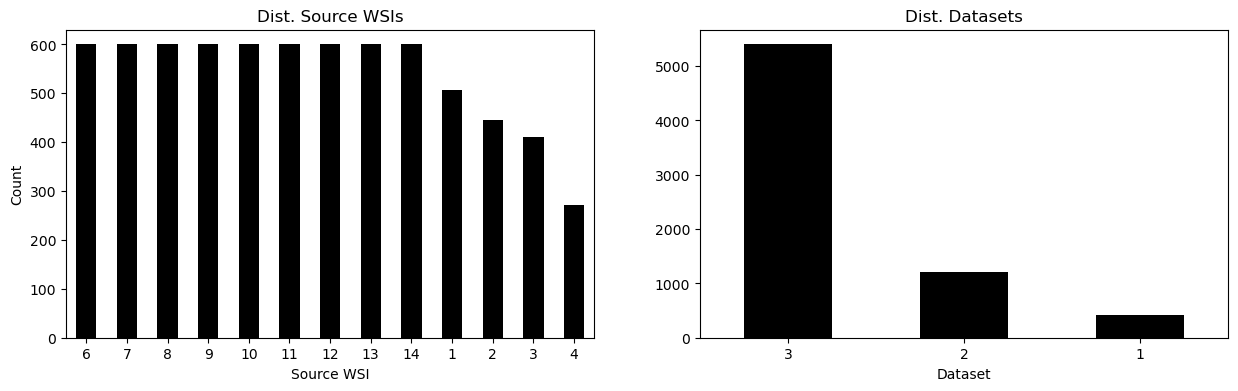

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
# Source WSIs.
tile_metadata.source_wsi.value_counts().plot(ax=axs[0], kind='bar', rot=0, color="black")
axs[0].set_title("Dist. Source WSIs")
axs[0].set_xlabel("Source WSI")
axs[0].set_ylabel("Count")

# Datasets.
tile_metadata.dataset.value_counts().plot(ax=axs[1], kind="bar", rot=0, color="black")
axs[1].set_title("Dist. Datasets")
axs[1].set_xlabel("Dataset")

- Ensure a representative distribution from all the WSIs for training and testing.
- Most instances are from dataset 3.

### Tile Vizualization
TIFF images of the tiles. Each tile is 512x512 in size.

#### Files
- **{train|test}/** Folders containing TIFF images of the tiles. Each tile is 512x512 in size.
- **polygons.jsonl** Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
    - `id:` Identifies the corresponding image in train/
    - `annotations:` A list of mask annotations with:
    - `type:` Identifies the type of structure annotated:
        - `blood_vessel:` The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
        - `glomerulus:` A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives. Annotations are provided for test set tiles in the hidden version of the dataset.
        - `unsure:` A structure the expert annotators cannot confidently distinguish as a blood vessel.
    - `coordinates:` A list of polygon coordinates defining the segmentation mask.


In [8]:
polygons = read_json(data_path/'polygons.jsonl')
polygons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1633 non-null   object
 1   annotations  1633 non-null   object
dtypes: object(2)
memory usage: 25.6+ KB



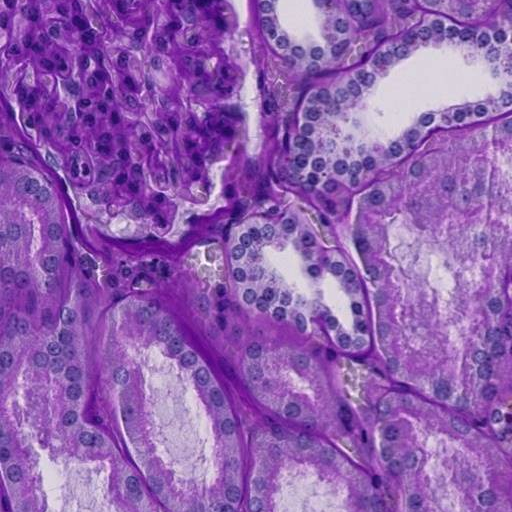

In [9]:
plot_annotated_image(polygons, '0006ff2aa7cd')


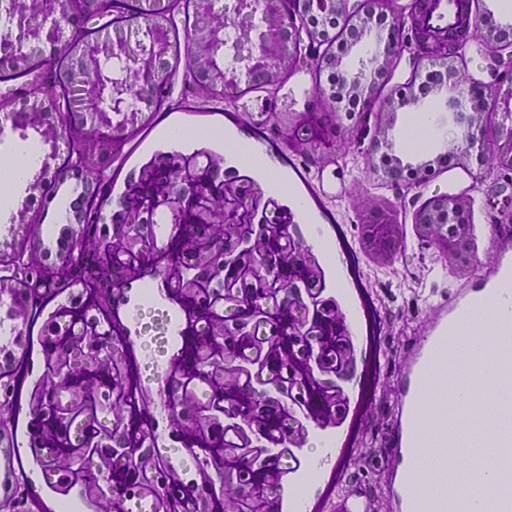

In [10]:
plot_annotated_image(polygons, '9b9349a10d8d')

Awesome!😃